In [ ]:
import pandas as pd
import numpy as np
from prophet import Prophet
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import random
from datetime import timedelta, date
import os
from google.colab import drive
import openpyxl # Import openpyxl for enhanced Excel writing
from openpyxl.styles import Font, PatternFill
from openpyxl.utils import get_column_letter
from openpyxl.formatting.rule import ColorScaleRule, CellIsRule
from openpyxl.styles.colors import Color

# --- Configuration ---
N_ITEMS = 250  # Number of imaginary items
START_DATE = '2022-01-01'
END_DATE = '2024-04-15' # Let's move the end date forward a bit for demoing new data
LEAD_TIME_WEEKS = 2
LEAD_TIME_DAYS = LEAD_TIME_WEEKS * 7
INITIAL_STOCK_MULTIPLIER = 60 # Initial stock covers roughly this many days of avg sales
REPLENISHMENT_ORDER_SIZE_WEEKS = 4 # Default order size for dashboard display (in weeks of demand)
SAFETY_STOCK_DAYS = 7 # Keep stock for 7 days of demand as safety stock

# --- Google Drive Setup ---
DRIVE_PATH = '/content/drive/MyDrive/WarehouseStockData' # Change this if you prefer a different path
HISTORICAL_DATA_FILENAME = 'historical_stock_data.xlsx' # Full historical data (raw)
FORECAST_SUMMARY_FILENAME = 'forecast_dashboard.xlsx' # Main Excel dashboard file
ITEM_PLOTS_FOLDER_NAME = 'item_forecast_plots' # Folder for individual item forecast plots
ITEM_PLOTS_FULL_PATH = os.path.join(DRIVE_PATH, ITEM_PLOTS_FOLDER_NAME)


# Mount Google Drive
drive.mount('/content/drive')

# Create directory if it doesn't exist
os.makedirs(DRIVE_PATH, exist_ok=True)
os.makedirs(ITEM_PLOTS_FULL_PATH, exist_ok=True) # Create folder for plots
historical_file_path = os.path.join(DRIVE_PATH, HISTORICAL_DATA_FILENAME)
forecast_summary_file_path = os.path.join(DRIVE_PATH, FORECAST_SUMMARY_FILENAME)

print(f"Working directory for data: {DRIVE_PATH}")
print(f"Individual item plots will be saved in: {ITEM_PLOTS_FULL_PATH}")

# --- Helper Function for Demand Generation (separated for clarity) ---
def generate_daily_demand(start_date, end_date, base_sales_mean, item_id):
    """
    Generates simulated daily demand (sales) for a given item and date range.
    """
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    df = pd.DataFrame({'ds': dates})

    df['daily_sales'] = base_sales_mean + np.random.normal(0, base_sales_mean * 0.1, len(df))

    # Add some seasonality (e.g., weekly, monthly, annual)
    df['daily_sales'] += np.sin(df['ds'].dt.dayofyear / 365 * 2 * np.pi) * (base_sales_mean * 0.2) # Annual
    df['daily_sales'] += np.sin(df['ds'].dt.dayofweek / 7 * 2 * np.pi) * (base_sales_mean * 0.1) # Weekly
    df['daily_sales'] = df['daily_sales'].apply(lambda x: max(1, round(x))) # Ensure positive and integer
    df['item_id'] = item_id
    return df[['item_id', 'ds', 'daily_sales']]

# --- Helper Function to Simulate Stock Levels based on Demand ---
def simulate_stock_from_demand(df_demand_history, initial_stock_multiplier, replenishment_order_size_weeks, lead_time_days, safety_stock_days):
    """
    Calculates stock levels for a given item's demand history.
    This function should be called on the *entire* historical demand data for an item
    to ensure proper replenishment simulation.
    """
    df = df_demand_history.sort_values('ds').copy()
    avg_daily_sales = df['daily_sales'].mean()

    # Initial stock is calculated based on overall average sales
    initial_stock = int(avg_daily_sales * initial_stock_multiplier)
    current_stock = initial_stock

    replenishment_threshold = int(avg_daily_sales * (lead_time_days + safety_stock_days))
    replenishment_amount = int(avg_daily_sales * (replenishment_order_size_weeks * 7))

    df['stock'] = 0 # Initialize stock column

    for i, row in df.iterrows():
        df.loc[i, 'stock'] = current_stock
        current_stock -= row['daily_sales']

        # If stock falls below threshold, simulate a replenishment arriving *today* for historical purposes
        # In real life, this would be a planned inbound shipment.
        if current_stock < replenishment_threshold and i < len(df) - lead_time_days:
            current_stock += replenishment_amount

    return df # Returns df with 'stock' column added/updated

# --- 1. Load or Generate Historical Data ---

df_all_items = pd.DataFrame()
current_end_date_dt = pd.to_datetime(END_DATE)

if os.path.exists(historical_file_path):
    print(f"Loading existing historical data from {historical_file_path}...")
    df_all_items = pd.read_excel(historical_file_path)
    df_all_items['ds'] = pd.to_datetime(df_all_items['ds']) # Ensure 'ds' is datetime
    print("Historical data loaded.")

    last_date_in_history = df_all_items['ds'].max()
    unique_item_ids = df_all_items['item_id'].unique()
    print(f"Last date in history: {last_date_in_history.strftime('%Y-%m-%d')}")

    if last_date_in_history < current_end_date_dt:
        print(f"New data needed from {last_date_in_history + timedelta(days=1).strftime('%Y-%m-%d')} to {current_end_date_dt.strftime('%Y-%m-%d')}")
        new_data_frames = []
        for item_id in unique_item_ids:
            # Get historical average for this item to ensure new demand is consistent
            item_hist_demand = df_all_items[df_all_items['item_id'] == item_id]['daily_sales']
            base_sales_mean = item_hist_demand.mean()

            new_demand_df = generate_daily_demand(
                start_date=last_date_in_history + timedelta(days=1),
                end_date=current_end_date_dt,
                base_sales_mean=base_sales_mean,
                item_id=item_id
            )
            new_data_frames.append(new_demand_df)

        if new_data_frames:
            df_new_demand = pd.concat(new_data_frames, ignore_index=True)
            # Combine old and new demand data
            df_all_items = pd.concat([df_all_items[['item_id', 'ds', 'daily_sales']], df_new_demand], ignore_index=True)
            df_all_items = df_all_items.sort_values(by=['item_id', 'ds']).reset_index(drop=True)
            print(f"Appended {len(df_new_demand)} new demand records.")
        else:
            print("No new dates to generate demand for.")
    else:
        print("No new demand data needed based on current END_DATE.")

    print("Recalculating stock for all historical data (including new demand, if any)...")
    # Re-simulate stock for all items as the replenishment logic is cumulative
    updated_stock_data = []
    for item_id in unique_item_ids:
        item_demand_history = df_all_items[df_all_items['item_id'] == item_id]
        updated_stock_data.append(
            simulate_stock_from_demand(
                item_demand_history,
                INITIAL_STOCK_MULTIPLIER,
                REPLENISHMENT_ORDER_SIZE_WEEKS,
                LEAD_TIME_DAYS,
                SAFETY_STOCK_DAYS
            )
        )
    df_all_items = pd.concat(updated_stock_data, ignore_index=True)
    print("Stock recalculation complete.")

else:
    print("No existing historical data found. Generating full history from scratch...")
    all_demand_data = []
    for i in range(1, N_ITEMS + 1):
        # Assign a random base sales for each new item
        base_sales = random.randint(5, 50) + random.random() * 5
        item_demand = generate_daily_demand(START_DATE, END_DATE, base_sales, f'ITEM_{i:04d}')
        all_demand_data.append(item_demand)

    df_all_items = pd.concat(all_demand_data, ignore_index=True)
    df_all_items = df_all_items.sort_values(by=['item_id', 'ds']).reset_index(drop=True)
    print(f"Generated demand data for {N_ITEMS} items.")

    print("Simulating initial stock levels...")
    # Simulate stock levels for the first time
    simulated_stock_data = []
    for item_id in df_all_items['item_id'].unique():
        item_demand_history = df_all_items[df_all_items['item_id'] == item_id]
        simulated_stock_data.append(
            simulate_stock_from_demand(
                item_demand_history,
                INITIAL_STOCK_MULTIPLIER,
                REPLENISHMENT_ORDER_SIZE_WEEKS,
                LEAD_TIME_DAYS,
                SAFETY_STOCK_DAYS
            )
        )
    df_all_items = pd.concat(simulated_stock_data, ignore_index=True)
    print("Initial stock simulation complete.")

# Save the updated/generated historical data (the raw data file)
print(f"Saving raw historical data to {historical_file_path}...")
df_all_items.to_excel(historical_file_path, index=False)
print("Raw historical data saved.")

print(f"\nTotal data points in history: {len(df_all_items)}")
print(df_all_items.tail())


# --- 2. Calculate Replenishment Needs using Prophet ---

def forecast_replenishment(item_data, lead_time_days, replenishment_order_size_weeks, safety_stock_days):
    """
    Forecasts demand using Prophet and calculates replenishment dates.
    """
    item_id = item_data['item_id'].iloc[0]
    prophet_df = item_data[['ds', 'daily_sales']].rename(columns={'daily_sales': 'y'}).copy()

    current_stock = item_data['stock'].iloc[-1]
    current_date = item_data['ds'].iloc[-1]
    avg_historical_demand = item_data['daily_sales'].mean()
    replenishment_qty = int(avg_historical_demand * (replenishment_order_size_weeks * 7))

    model = Prophet(
        seasonality_mode='multiplicative',
        interval_width=0.95,
        daily_seasonality=False
    )
    model.add_seasonality(name='weekly', period=7, fourier_order=3)
    model.add_seasonality(name='yearly', period=365.25, fourier_order=10)

    try:
        model.fit(prophet_df)
    except Exception as e:
        print(f"Prophet failed to fit for {item_id}: {e}")
        return {
            'item_id': item_id,
            'current_stock': current_stock,
            'avg_daily_demand': avg_historical_demand,
            'depletion_date': 'N/A',
            'reorder_date': 'N/A',
            'days_to_depletion': -1,
            'days_to_reorder': -1,
            'replenishment_qty': replenishment_qty,
            'status': 'Failed to forecast',
            'forecast_data': pd.DataFrame() # Empty DataFrame for failed forecasts
        }

    future_days = 90 + lead_time_days
    future = model.make_future_dataframe(periods=future_days, include_history=True)
    forecast = model.predict(future)

    forecast_from_today = forecast[forecast['ds'] >= current_date].copy()
    forecast_from_today['yhat'] = forecast_from_today['yhat'].apply(lambda x: max(1, round(x)))

    simulated_stock = current_stock
    depletion_date = None
    days_to_depletion = -1

    for i, row in forecast_from_today[forecast_from_today['ds'] > current_date].iterrows():
        simulated_stock -= row['yhat']
        if simulated_stock <= safety_stock_days:
            depletion_date = row['ds']
            days_to_depletion = (depletion_date - current_date).days
            break

    if depletion_date is None:
        status = "Stock sufficient for >90 days"
        reorder_date = 'N/A'
        days_to_reorder = -1
    else:
        reorder_date = depletion_date - timedelta(days=lead_time_days)
        days_to_reorder = (reorder_date - current_date).days
        status = "Needs replenishment"
        if days_to_reorder <= 0:
            status = "Immediate replenishment needed!"

    return {
        'item_id': item_id,
        'current_stock': current_stock,
        'avg_daily_demand': avg_historical_demand,
        'depletion_date': depletion_date,
        'reorder_date': reorder_date,
        'days_to_depletion': days_to_depletion,
        'days_to_reorder': days_to_reorder,
        'replenishment_qty': replenishment_qty,
        'status': status,
        'forecast_data': forecast # Keep full forecast for plotting
    }

print("\nForecasting replenishment for each item (this may take a moment)...")
replenishment_results = []
item_ids = df_all_items['item_id'].unique()
for i, item_id in enumerate(item_ids):
    if (i + 1) % 50 == 0:
        print(f"  Processed {i+1}/{len(item_ids)} items.")
    item_df = df_all_items[df_all_items['item_id'] == item_id]
    result = forecast_replenishment(item_df, LEAD_TIME_DAYS, REPLENISHMENT_ORDER_SIZE_WEEKS, SAFETY_STOCK_DAYS)
    replenishment_results.append(result)

replenishment_summary_df = pd.DataFrame([r for r in replenishment_results if r['status'] != 'Failed to forecast'])

# Sort by reorder_date first, converting N/A to a large number so they sort last
# Convert non-timestamp values to a large value for sorting
replenishment_summary_df['reorder_date_sort'] = replenishment_summary_df['reorder_date'].apply(
    lambda x: x.timestamp() if isinstance(x, pd.Timestamp) else float('inf')
)
replenishment_summary_df = replenishment_summary_df.sort_values(by='reorder_date_sort', ascending=True).drop(columns=['reorder_date_sort'])


print("\nReplenishment Summary (Top 10):")
print(replenishment_summary_df.head(10))


# --- 3. Generate Individual Item Plots and Save as HTML ---

print(f"\nGenerating detailed plots for all {len(replenishment_summary_df)} items and saving as HTML files...")

plotly_html_links_relative = {} # To store mapping of item_id to its RELATIVE HTML file path

for idx, item_info in replenishment_summary_df.iterrows(): # Iterate over all items in summary
    item_id = item_info['item_id']
    # Get all historical data for this item (to include full history in plot)
    historical_data = df_all_items[df_all_items['item_id'] == item_id].copy()
    # Get the forecast data specific to this item (from the summary df)
    forecast_data = item_info['forecast_data'].copy() # This column is now a DataFrame itself

    current_stock = item_info['current_stock']
    depletion_date = item_info['depletion_date']
    reorder_date = item_info['reorder_date']
    replenishment_qty = item_info['replenishment_qty'] # Use replenishment qty for plot scaling

    # Ensure 'ds' column is datetime type
    historical_data['ds'] = pd.to_datetime(historical_data['ds'])
    forecast_data['ds'] = pd.to_datetime(forecast_data['ds'])

    fig = make_subplots(rows=2, cols=1,
                        subplot_titles=(f"Item {item_id}: Demand Forecast", f"Item {item_id}: Simulated Stock Depletion"),
                        vertical_spacing=0.2)

    # Plot 1: Demand Forecast
    fig.add_trace(go.Scatter(x=historical_data['ds'], y=historical_data['daily_sales'],
                             mode='lines', name='Actual Daily Sales', line=dict(color='blue')),
                  row=1, col=1)
    fig.add_trace(go.Scatter(x=forecast_data['ds'], y=forecast_data['yhat'],
                             mode='lines', name='Forecasted Daily Sales (yhat)', line=dict(color='red')),
                  row=1, col=1)
    fig.add_trace(go.Scatter(x=forecast_data['ds'], y=forecast_data['yhat_lower'],
                             mode='lines', name='yhat Lower', line=dict(color='red', dash='dot'), showlegend=False),
                  row=1, col=1)
    fig.add_trace(go.Scatter(x=forecast_data['ds'], y=forecast_data['yhat_upper'],
                             mode='lines', name='yhat Upper', line=dict(color='red', dash='dot'), fill='tonexty', fillcolor='rgba(255,0,0,0.1)', showlegend=False),
                  row=1, col=1)


    # Plot 2: Simulated Stock Depletion
    sim_stock_dates = []
    sim_stock_levels = []
    current_sim_stock = current_stock
    today = historical_data['ds'].iloc[-1]

    sim_stock_dates.extend(historical_data['ds'].tolist())
    sim_stock_levels.extend(historical_data['stock'].tolist())

    future_forecast = forecast_data[forecast_data['ds'] > today].copy()
    for _, row in future_forecast.iterrows():
        sim_stock_dates.append(row['ds'])
        current_sim_stock -= row['yhat']
        sim_stock_levels.append(max(0, current_sim_stock))

    fig.add_trace(go.Scatter(x=sim_stock_dates, y=sim_stock_levels,
                             mode='lines', name='Simulated Stock Level', line=dict(color='green')),
                  row=2, col=1)
    fig.add_trace(go.Scatter(x=[historical_data['ds'].iloc[-1]], y=[current_stock],
                             mode='markers', marker=dict(color='darkgreen', size=10), name='Current Stock',
                             text=f"Current Stock: {current_stock:,.0f}",
                             hovertemplate="<b>Date:</b> %{x}<br><b>Stock:</b> %{y:,.0f}<extra></extra>"),
                  row=2, col=1)

    max_y_stock = max(current_stock, replenishment_qty * 1.5, 100)
    if not isinstance(replenishment_qty, (int, float)) or replenishment_qty == 0:
        max_y_stock = max(current_stock, historical_data['daily_sales'].mean() * (REPLENISHMENT_ORDER_SIZE_WEEKS * 7) * 1.5, 100)

    fig.update_yaxes(title_text="Stock Level", row=2, col=1, range=[0, max_y_stock])

    # Add reorder and depletion markers using separate annotation calls
    if isinstance(depletion_date, pd.Timestamp):
        depletion_date_str = depletion_date.strftime('%Y-%m-%d')
        fig.add_vline(x=depletion_date_str, line_width=2, line_dash="dot", line_color="red",
                      row=2, col=1)
        fig.add_annotation(xref="x2", yref="y2",
                           x=depletion_date_str, y=max_y_stock * 0.95, # Place near top of chart
                           text=f"Depletion: {depletion_date.strftime('%Y-%m-%d')}",
                           showarrow=False,
                           font=dict(color="red", size=10),
                           align="center",
                           bgcolor="rgba(255, 255, 255, 0.7)", bordercolor="red", borderwidth=1, borderpad=2,
                           row=2, col=1)
    if isinstance(reorder_date, pd.Timestamp):
        reorder_date_str = reorder_date.strftime('%Y-%m-%d')
        fig.add_vline(x=reorder_date_str, line_width=2, line_dash="dash", line_color="orange",
                      row=2, col=1)
        fig.add_annotation(xref="x2", yref="y2",
                           x=reorder_date_str, y=max_y_stock * 0.85, # Stagger slightly below depletion date
                           text=f"Reorder By: {reorder_date.strftime('%Y-%m-%d')}",
                           showarrow=False,
                           font=dict(color="orange", size=10),
                           align="center",
                           bgcolor="rgba(255, 255, 255, 0.7)", bordercolor="orange", borderwidth=1, borderpad=2,
                           row=2, col=1)

    # Safety stock horizontal line with annotation
    fig.add_hline(y=SAFETY_STOCK_DAYS, line_width=1, line_dash="longdash", line_color="grey",
                  annotation_text=f"Safety Stock ({SAFETY_STOCK_DAYS} days)", annotation_position="top right",
                  row=2, col=1)


    fig.update_layout(
        height=800,
        title_text=f"Item {item_id} Stock & Replenishment Forecast",
        title_x=0.5,
        hovermode="x unified"
    )
    fig.update_xaxes(title_text="Date", row=1, col=1)
    fig.update_yaxes(title_text="Daily Sales", row=1, col=1)
    fig.update_xaxes(title_text="Date", row=2, col=1)

    # Save the plot as an HTML file
    plot_filename = f"{item_id}_forecast.html"
    plot_filepath = os.path.join(ITEM_PLOTS_FULL_PATH, plot_filename)
    fig.write_html(plot_filepath)
    # Store a relative path that will work when downloaded with the Excel file
    plotly_html_links_relative[item_id] = os.path.join(ITEM_PLOTS_FOLDER_NAME, plot_filename)

print("Finished generating individual item plots and saving as HTML files.")

# --- Save the forecast summary to Excel with formatting and plot links ---
print(f"Saving forecast summary to {forecast_summary_file_path} (with clickable plot links and formatting)...")

# Prepare the summary DataFrame for Excel
# IMPORTANT: Explicitly select columns to save, excluding 'forecast_data'
columns_to_save = [
    'item_id', 'current_stock', 'avg_daily_demand',
    'depletion_date', 'reorder_date', 'days_to_depletion',
    'days_to_reorder', 'replenishment_qty', 'status'
]
excel_summary_df = replenishment_summary_df[columns_to_save].copy()

# Convert datetime columns to string before saving to Excel to avoid format issues
excel_summary_df['depletion_date'] = excel_summary_df['depletion_date'].apply(lambda x: x.strftime('%Y-%m-%d') if isinstance(x, pd.Timestamp) else str(x))
excel_summary_df['reorder_date'] = excel_summary_df['reorder_date'].apply(lambda x: x.strftime('%Y-%m-%d') if isinstance(x, pd.Timestamp) else str(x))

# Add the Plot_Link column *after* selecting the other columns
excel_summary_df['Plot_Link'] = excel_summary_df['item_id'].apply(lambda x: plotly_html_links_relative.get(x, "N/A"))

# Write to Excel using pandas to_excel, then enhance with openpyxl
with pd.ExcelWriter(forecast_summary_file_path, engine='openpyxl') as writer:
    excel_summary_df.to_excel(writer, sheet_name='Forecast Dashboard', index=False)

    workbook = writer.book
    sheet = workbook['Forecast Dashboard']

    # 1. Apply AutoFilter
    sheet.auto_filter.ref = sheet.dimensions

    # 2. Freeze Panes (1 row + 0 columns)
    sheet.freeze_panes = 'A2'

    # 3. Adjust Column Widths
    for col_idx, column_name in enumerate(excel_summary_df.columns, 1):
        # Calculate max width based on header and cell content
        max_length = len(str(column_name))
        # Iterate over the first few rows to estimate content length, or all if performance is not an issue
        for row_idx in range(1, min(sheet.max_row, 100)): # Check up to 100 rows for content width
            cell_value = str(sheet.cell(row=row_idx, column=col_idx).value)
            if cell_value:
                max_length = max(max_length, len(cell_value))
        adjusted_width = (max_length + 2) * 1.1 # Add some padding and multiplier for readability
        sheet.column_dimensions[get_column_letter(col_idx)].width = adjusted_width

    # 4. Add Clickable Hyperlinks to 'Plot_Link' column
    # Find the column index for 'Plot_Link'
    plot_link_col_idx = -1
    for col_idx, cell in enumerate(sheet[1]): # Iterate over the first row (headers)
        if cell.value == 'Plot_Link':
            plot_link_col_idx = col_idx + 1 # openpyxl is 1-indexed
            break

    if plot_link_col_idx != -1:
        hyperlink_font = Font(underline="single", color=Color(rgb="0000FF")) # Blue color for links
        for row_idx in range(2, sheet.max_row + 1): # Start from row 2 (after header)
            cell = sheet.cell(row=row_idx, column=plot_link_col_idx)
            link_text = cell.value # This holds the relative path like 'item_forecast_plots/ITEM_0001_forecast.html'

            if link_text and link_text != "N/A":
                # For Excel hyperlinks, the path should be relative to the Excel file itself.
                # Assuming 'item_forecast_plots' folder is sibling to the Excel file.
                cell.hyperlink = link_text # Openpyxl handles relative paths well
                cell.font = hyperlink_font
                cell.value = "View Plot" # Display "View Plot" text

    # 5. Conditional Formatting
    # Get column index for 'Days to Reorder' and 'Status'
    days_to_reorder_col_letter = None
    status_col_letter = None
    for col_idx, cell in enumerate(sheet[1]):
        if cell.value == 'Days to Reorder':
            days_to_reorder_col_letter = get_column_letter(col_idx + 1)
        elif cell.value == 'Status':
            status_col_letter = get_column_letter(col_idx + 1)

    if days_to_reorder_col_letter:
        # Rule 1: Immediate replenishment (Days to Reorder <= 0) - Red background
        red_fill = PatternFill(start_color="FFC7CE", end_color="FFC7CE", fill_type="solid") # Light Red
        sheet.conditional_formatting.add(
            f'{days_to_reorder_col_letter}2:{days_to_reorder_col_letter}{sheet.max_row}',
            CellIsRule(operator='lessThanOrEqual', formula=[0], fill=red_fill)
        )
        # Rule 2: Approaching replenishment (Days to Reorder <= LEAD_TIME_DAYS) - Yellow background
        yellow_fill = PatternFill(start_color="FFEB9C", end_color="FFEB9C", fill_type="solid") # Light Yellow
        sheet.conditional_formatting.add(
            f'{days_to_reorder_col_letter}2:{days_to_reorder_col_letter}{sheet.max_row}',
            CellIsRule(operator='lessThanOrEqual', formula=[LEAD_TIME_DAYS], fill=yellow_fill)
        )

    if status_col_letter:
        # Rule for 'Immediate replenishment needed!' in Status column
        red_font = Font(color=Color(rgb="9C0006"), bold=True) # Dark Red Font
        red_fill = PatternFill(start_color="FFC7CE", end_color="FFC7CE", fill_type="solid") # Light Red Background
        sheet.conditional_formatting.add(
            f'{status_col_letter}2:{status_col_letter}{sheet.max_row}',
            CellIsRule(operator='equal', formula=['"Immediate replenishment needed!"'], fill=red_fill, font=red_font)
        )

print(f"Forecast summary saved as {forecast_summary_file_path}.")
print("\nExcel dashboard generated successfully. Please download the .xlsx file and the 'item_forecast_plots' folder from Google Drive.")
print("Place them in the same local directory for the plot links to work.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Working directory for data: /content/drive/MyDrive/WarehouseStockData
Individual item plots will be saved in: /content/drive/MyDrive/WarehouseStockData/item_forecast_plots
Loading existing historical data from /content/drive/MyDrive/WarehouseStockData/historical_stock_data.xlsx...
Historical data loaded.
Last date in history: 2024-04-15
No new demand data needed based on current END_DATE.
Recalculating stock for all historical data (including new demand, if any)...
Stock recalculation complete.
Saving raw historical data to /content/drive/MyDrive/WarehouseStockData/historical_stock_data.xlsx...


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphxjqw_up/apxp9jl6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphxjqw_up/7dwzslqj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85960', 'data', 'file=/tmp/tmphxjqw_up/apxp9jl6.json', 'init=/tmp/tmphxjqw_up/7dwzslqj.json', 'output', 'file=/tmp/tmphxjqw_up/prophet_model8ce9wa15/prophet_model-20250522194930.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:49:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:49:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Raw historical data saved.

Total data points in history: 209000
          item_id         ds  daily_sales  stock
208995  ITEM_0250 2024-04-11           60 -36056
208996  ITEM_0250 2024-04-12           47 -36116
208997  ITEM_0250 2024-04-13           52 -36163
208998  ITEM_0250 2024-04-14           51 -36215
208999  ITEM_0250 2024-04-15           48 -36266

Forecasting replenishment for each item (this may take a moment)...


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphxjqw_up/fvok6qhx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphxjqw_up/_322zir_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98976', 'data', 'file=/tmp/tmphxjqw_up/fvok6qhx.json', 'init=/tmp/tmphxjqw_up/_322zir_.json', 'output', 'file=/tmp/tmphxjqw_up/prophet_modelud9h8gk2/prophet_model-20250522194930.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:49:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:49:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly'

  Processed 50/250 items.


19:49:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphxjqw_up/tughdr7o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphxjqw_up/gbgjefwl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96774', 'data', 'file=/tmp/tmphxjqw_up/tughdr7o.json', 'init=/tmp/tmphxjqw_up/gbgjefwl.json', 'output', 'file=/tmp/tmphxjqw_up/prophet_model4sttmvk_/prophet_model-20250522194951.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:49:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:49:51 - cmdstanpy - INFO - Chain [1] done process

  Processed 100/250 items.


19:50:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphxjqw_up/fmbwu7_1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphxjqw_up/cjarec_l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46820', 'data', 'file=/tmp/tmphxjqw_up/fmbwu7_1.json', 'init=/tmp/tmphxjqw_up/cjarec_l.json', 'output', 'file=/tmp/tmphxjqw_up/prophet_modelc9m40aef/prophet_model-20250522195011.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:50:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:50:11 - cmdstanpy - INFO - Chain [1] done process

  Processed 150/250 items.


19:50:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphxjqw_up/6j_s94_1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphxjqw_up/irn3y769.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53650', 'data', 'file=/tmp/tmphxjqw_up/6j_s94_1.json', 'init=/tmp/tmphxjqw_up/irn3y769.json', 'output', 'file=/tmp/tmphxjqw_up/prophet_model6koupp3f/prophet_model-20250522195031.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:50:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:50:31 - cmdstanpy - INFO - Chain [1] done process

  Processed 200/250 items.


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphxjqw_up/sj8unimu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphxjqw_up/4w0y6p0m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66654', 'data', 'file=/tmp/tmphxjqw_up/sj8unimu.json', 'init=/tmp/tmphxjqw_up/4w0y6p0m.json', 'output', 'file=/tmp/tmphxjqw_up/prophet_modelx56j86z0/prophet_model-20250522195052.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:50:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:50:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly'

  Processed 250/250 items.

Replenishment Summary (Top 10):
      item_id  current_stock  avg_daily_demand depletion_date reorder_date  \
1   ITEM_0002         -31024         40.044258     2024-04-16   2024-04-02   
2   ITEM_0003          -9237         11.927033     2024-04-16   2024-04-02   
3   ITEM_0004         -27654         35.694976     2024-04-16   2024-04-02   
4   ITEM_0005         -17305         22.337321     2024-04-16   2024-04-02   
6   ITEM_0007          -5541          7.151914     2024-04-16   2024-04-02   
5   ITEM_0006         -30198         38.974880     2024-04-16   2024-04-02   
7   ITEM_0008         -39351         50.778708     2024-04-16   2024-04-02   
8   ITEM_0009          -9435         12.177033     2024-04-16   2024-04-02   
12  ITEM_0013          -6489          8.373206     2024-04-16   2024-04-02   
9   ITEM_0010         -38526         49.720096     2024-04-16   2024-04-02   

    days_to_depletion  days_to_reorder  replenishment_qty  \
1                   

In [ ]:
pip install prophet matplotlib pandas numpy

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp42qv4a_y/oekor7mz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp42qv4a_y/455_1taf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58965', 'data', 'file=/tmp/tmp42qv4a_y/oekor7mz.json', 'init=/tmp/tmp42qv4a_y/455_1taf.json', 'output', 'file=/tmp/tmp42qv4a_y/prophet_models7qf_ooh/prophet_model-20250521052329.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:23:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:23:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


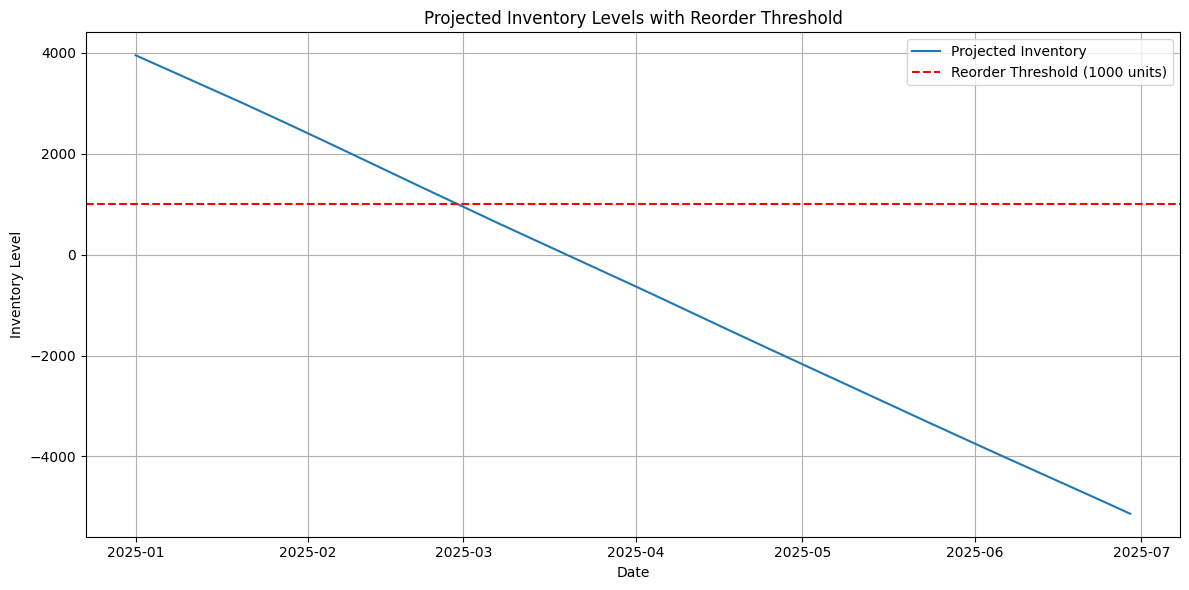

⚠️ Inventory will fall below 1000 units by 2025-02-28.


In [ ]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt

# Simulate historical sales data
np.random.seed(42)
dates = pd.date_range(start='2022-01-01', end='2024-12-31', freq='D')
sales = np.random.poisson(lam=50, size=len(dates))

# Current inventory level (example value)
current_inventory = 4000  # Current stock level (units)

# Create DataFrame for Prophet
sales_data = pd.DataFrame({
    'ds': dates,
    'y': sales
})

# Train Prophet model
model = Prophet()
model.fit(sales_data)

# Forecast the next 180 days
future_dates = model.make_future_dataframe(periods=180)
forecast = model.predict(future_dates)

# Calculate cumulative forecasted sales from today onwards
forecasted_sales = forecast[forecast['ds'] > dates[-1]].copy()
forecasted_sales['cumulative_sales'] = forecasted_sales['yhat'].cumsum()

# Calculate projected inventory levels
forecasted_sales['projected_inventory'] = current_inventory - forecasted_sales['cumulative_sales']

# Define reorder threshold (e.g., when inventory falls below 1000 units)
reorder_threshold = 1000

# Plot projected inventory levels with reorder threshold
plt.figure(figsize=(12, 6))
plt.plot(forecasted_sales['ds'], forecasted_sales['projected_inventory'], label='Projected Inventory')
plt.axhline(y=reorder_threshold, color='r', linestyle='--', label='Reorder Threshold (1000 units)')
plt.title('Projected Inventory Levels with Reorder Threshold')
plt.xlabel('Date')
plt.ylabel('Inventory Level')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print date when inventory crosses threshold
below_threshold = forecasted_sales[forecasted_sales['projected_inventory'] <= reorder_threshold]
if not below_threshold.empty:
    reorder_date = below_threshold.iloc[0]['ds'].date()
    print(f"⚠️ Inventory will fall below {reorder_threshold} units by {reorder_date}.")
else:
    print(f"✅ Inventory stays above the threshold ({reorder_threshold} units) for the next 180 days.")




INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp42qv4a_y/n54o37m4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp42qv4a_y/9gtua26h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46906', 'data', 'file=/tmp/tmp42qv4a_y/n54o37m4.json', 'init=/tmp/tmp42qv4a_y/9gtua26h.json', 'output', 'file=/tmp/tmp42qv4a_y/prophet_model5pslv6tz/prophet_model-20250521052437.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:24:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:24:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


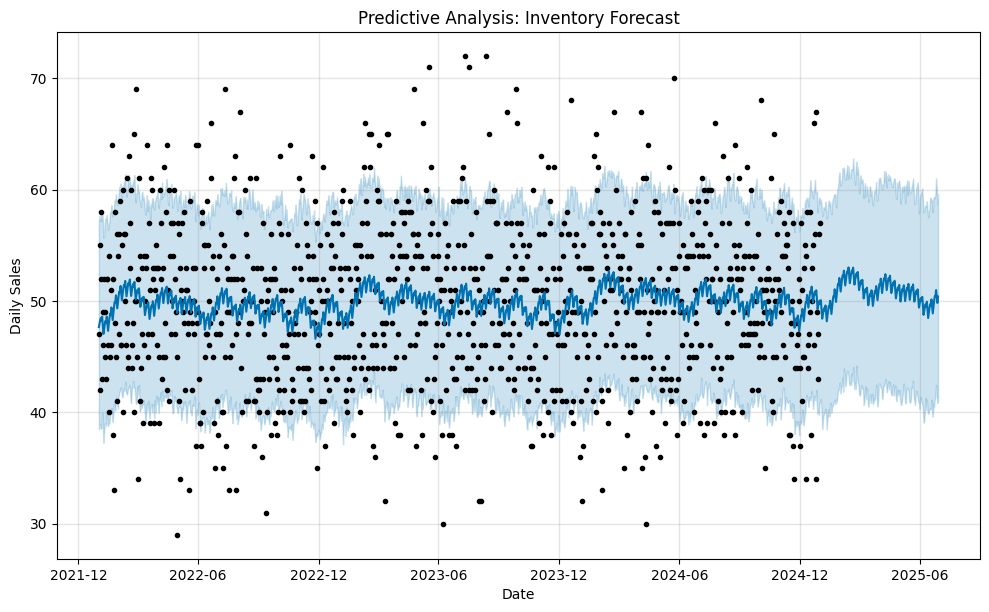

In [ ]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt

# Simulate historical sales data
np.random.seed(42)
dates = pd.date_range(start='2022-01-01', end='2024-12-31', freq='D')
sales = np.random.poisson(lam=50, size=len(dates))

# Prepare DataFrame
sales_data = pd.DataFrame({
    'ds': dates,
    'y': sales
})

# Train the Prophet model
model = Prophet()
model.fit(sales_data)

# Forecast next 180 days (6 months)
future_dates = model.make_future_dataframe(periods=180)
forecast = model.predict(future_dates)

# Plot the results
fig = model.plot(forecast)
plt.title('Predictive Analysis: Inventory Forecast')
plt.xlabel('Date')
plt.ylabel('Daily Sales')
plt.show()

In [ ]:
!pip install pandas numpy prophet plotly kaleido # kaleido for static image export, if needed

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.6 MB/s eta 0:00:00
